# Chapter 6
## Deep learning


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Get familiar with a state-of-the-art framework for deep learning
1. Implement and run a convolutional neural network
1. See what convolution does

In [4]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import os, json
import scipy.signal as ss

In [5]:
mlp_output_folder = "chainermlp/"
cnn_output_folder = "chainercnn/"

def get_losses(output_folder):

    with open(os.path.join(output_folder, "log")) as data_file:
        data = json.load(data_file)

    training_loss = map(lambda x: x["main/loss"], data)
    validation_loss = map(lambda x: x["validation/main/loss"], data)
    
    return training_loss, validation_loss

When working on a state-of-the-art neural network project you would rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a convolutional neural network in the Chainer framework. At the moment we use this framework for most of the work in our group as it is flexible and has quite intuitive and pythonic syntax.  

Due to the popularity of deep learning various [Neural Network Frameworks](http://chainer.readthedocs.io/en/latest/comparison.html) exist, and it is unclear whether one of them will "win". Among those mentioned, Chainer and PyTorch (which is quite popular right now) have very similar syntax, and in fact PyTorch started as a fork from Chainer, reimplementing core functionality such as autograd in C++. This makes it faster, but less versatile. Google is developing and promoting the TensorFlow framework, which is fast for statically defined neural network flows. 


In this assignment you will follow a Chainer tutorial for implementing a standard multi-layer perceptron and a convolutional neural network. You will first copy the tutorial code and then make several adaptations. For a few steps you should consult the documentation or example code to check out how to implement them. 

### Exercise 1 (3 points)

Read the tutorial at https://docs.chainer.org/en/stable/tutorial/basic.html. As you go along, transfer the code for the Multi-Layer Perceptron example on MNIST into the notebook (and try running it). Use the variant that makes use of the Trainer framework, i.e. you do not need to handle the gradients yourself. 

Change the MLP training code so that it is similar to the MLP we implemented in the MLP exercise, i.e. it should use: 

1. A single hidden layer of 16 units (that is, two weight layers)
1. ReLU activation function
1. Stochastic Gradient Descent with a learning rate of 0.001 as optimizer
1. Training should do 50 iterations over the training set

For **evaluating the model**, set up the `trainer` object as follows: 
1. When initializing the `trainer` object, set the output folder to be `mlp_output_folder`.
1. Extend your `trainer` object with an `Evaluator` object that evaluates your `model` on the test set. 
1. Extend your `trainer` object with the `LogReport()` object. 
1. For printing the current model performance underneath the cell, extend the `trainer` object with a `PrintReport` object. Use the keys `"epoch"`, `"main/accuracy"`, `"validation/main/accuracy"`,  `"main/loss"` and `"validation/main/loss"`.
1. For plotting the accuracy and losses over epochs, extend the `trainer` object with a `PlotReport` object. Use the same keys as for `PrintReport` except `"epoch"`. Set the file name to `mlp_plot.png`.

Embed the generated `mlp_plot.png` underneath your code via `<img src='chainermlp/mlp_plot.png'>`. **Please additionally attach `mlp_plot.png` to your submission.**

In [6]:
# Load the MNIST data set as 784-length vectors (default): 
train, test = datasets.get_mnist()
print("Shape of a single example:", train[0][0].shape)

Shape of a single example: (784,)


### Solution 1

In [127]:
# Your MLP, including output
    ### Add your code here ###
    
train_iter = iterators.SerialIterator(train, batch_size = 100, shuffle = True)
test_iter = iterators.SerialIterator(test, batch_size = 100, repeat = False, shuffle = False)



class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y
    
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({"loss: ": loss, "accuracy: " : accuracy}, self)
        return loss
    
model = L.Classifier(MLP(16,10))
optimizer = optimizers.SGD(lr = 0.001)
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (50, 'epoch'), out='mlp_output_folder')

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"]))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(["main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"], file_name = "mlp_plot.png"))
trainer.run()




epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
     total [..................................................]  0.33%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  0.67%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 50 epochs
    364.93 iters/sec. Estimated time to finish: 0:01:21.659865.
     total [..................................................]  1.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 50 epochs
     336.5 iters/sec. Estimated time to finish: 0:01:28.262689.
     total [..................................................]  1.33%
this epoch [#################################.................] 66.67%
       400 iter, 0 epoch / 50 epochs
    331.86 it

     total [#####.............................................] 11.00%
this epoch [#########################.........................] 50.00%
      3300 iter, 5 epoch / 50 epochs
    268.76 iters/sec. Estimated time to finish: 0:01:39.345893.
     total [#####.............................................] 11.33%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 50 epochs
    269.85 iters/sec. Estimated time to finish: 0:01:38.574401.
     total [#####.............................................] 11.67%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 50 epochs
    270.65 iters/sec. Estimated time to finish: 0:01:37.912202.
6           0.594317       0.6395                    1.42876     1.33046               
     total [######............................................] 12.00%
this epoch [..................................................]  0.00%
      3600 iter, 6 epoch / 50 epochs
    

     total [##########........................................] 21.67%
this epoch [#########################################.........] 83.33%
      6500 iter, 10 epoch / 50 epochs
    257.48 iters/sec. Estimated time to finish: 0:01:31.268642.
11          0.797733       0.8128                    0.823628    0.771687              
     total [###########.......................................] 22.00%
this epoch [..................................................]  0.00%
      6600 iter, 11 epoch / 50 epochs
     255.8 iters/sec. Estimated time to finish: 0:01:31.478487.
     total [###########.......................................] 22.33%
this epoch [########..........................................] 16.67%
      6700 iter, 11 epoch / 50 epochs
    254.89 iters/sec. Estimated time to finish: 0:01:31.410805.
     total [###########.......................................] 22.67%
this epoch [################..................................] 33.33%
      6800 iter, 11 epoch / 50 epochs


     total [################..................................] 32.33%
this epoch [########..........................................] 16.67%
      9700 iter, 16 epoch / 50 epochs
    258.37 iters/sec. Estimated time to finish: 0:01:18.570125.
     total [################..................................] 32.67%
this epoch [################..................................] 33.33%
      9800 iter, 16 epoch / 50 epochs
    258.89 iters/sec. Estimated time to finish: 0:01:18.024522.
     total [################..................................] 33.00%
this epoch [#########################.........................] 50.00%
      9900 iter, 16 epoch / 50 epochs
    259.69 iters/sec. Estimated time to finish: 0:01:17.398554.
     total [################..................................] 33.33%
this epoch [#################################.................] 66.67%
     10000 iter, 16 epoch / 50 epochs
     260.2 iters/sec. Estimated time to finish: 0:01:16.863617.
     total [############

     total [#####################.............................] 43.00%
this epoch [#########################.........................] 50.00%
     12900 iter, 21 epoch / 50 epochs
    263.12 iters/sec. Estimated time to finish: 0:01:04.988167.
     total [#####################.............................] 43.33%
this epoch [#################################.................] 66.67%
     13000 iter, 21 epoch / 50 epochs
    263.77 iters/sec. Estimated time to finish: 0:01:04.449294.
     total [#####################.............................] 43.67%
this epoch [#########################################.........] 83.33%
     13100 iter, 21 epoch / 50 epochs
    264.84 iters/sec. Estimated time to finish: 0:01:03.812797.
22          0.8677         0.8757                    0.475231    0.450634              
     total [######################............................] 44.00%
this epoch [..................................................]  0.00%
     13200 iter, 22 epoch / 50 epochs


     total [##########################........................] 53.67%
this epoch [#########################################.........] 83.33%
     16100 iter, 26 epoch / 50 epochs
       274 iters/sec. Estimated time to finish: 0:00:50.730117.
27          0.878283       0.8846                    0.430252    0.408454              
     total [###########################.......................] 54.00%
this epoch [..................................................]  0.00%
     16200 iter, 27 epoch / 50 epochs
       273 iters/sec. Estimated time to finish: 0:00:50.549928.
     total [###########################.......................] 54.33%
this epoch [########..........................................] 16.67%
     16300 iter, 27 epoch / 50 epochs
    271.31 iters/sec. Estimated time to finish: 0:00:50.495729.
     total [###########################.......................] 54.67%
this epoch [################..................................] 33.33%
     16400 iter, 27 epoch / 50 epochs


     total [################################..................] 64.33%
this epoch [########..........................................] 16.67%
     19300 iter, 32 epoch / 50 epochs
    272.98 iters/sec. Estimated time to finish: 0:00:39.197264.
     total [################################..................] 64.67%
this epoch [################..................................] 33.33%
     19400 iter, 32 epoch / 50 epochs
    273.73 iters/sec. Estimated time to finish: 0:00:38.724476.
     total [################################..................] 65.00%
this epoch [#########################.........................] 50.00%
     19500 iter, 32 epoch / 50 epochs
    273.83 iters/sec. Estimated time to finish: 0:00:38.344949.
     total [################################..................] 65.33%
this epoch [#################################.................] 66.67%
     19600 iter, 32 epoch / 50 epochs
    275.29 iters/sec. Estimated time to finish: 0:00:37.778612.
     total [############

     total [#####################################.............] 75.00%
this epoch [#########################.........................] 50.00%
     22500 iter, 37 epoch / 50 epochs
    276.85 iters/sec. Estimated time to finish: 0:00:27.090131.
     total [#####################################.............] 75.33%
this epoch [#################################.................] 66.67%
     22600 iter, 37 epoch / 50 epochs
    279.17 iters/sec. Estimated time to finish: 0:00:26.506778.
     total [#####################################.............] 75.67%
this epoch [#########################################.........] 83.33%
     22700 iter, 37 epoch / 50 epochs
    280.88 iters/sec. Estimated time to finish: 0:00:25.989380.
38          0.889783       0.8949                    0.381092    0.362023              
     total [######################################............] 76.00%
this epoch [..................................................]  0.00%
     22800 iter, 38 epoch / 50 epochs


     total [##########################################........] 85.67%
this epoch [#########################################.........] 83.33%
     25700 iter, 42 epoch / 50 epochs
    283.71 iters/sec. Estimated time to finish: 0:00:15.156105.
43          0.89395        0.8972                    0.367664    0.350051              
     total [###########################################.......] 86.00%
this epoch [..................................................]  0.00%
     25800 iter, 43 epoch / 50 epochs
    283.07 iters/sec. Estimated time to finish: 0:00:14.837484.
     total [###########################################.......] 86.33%
this epoch [########..........................................] 16.67%
     25900 iter, 43 epoch / 50 epochs
       282 iters/sec. Estimated time to finish: 0:00:14.538832.
     total [###########################################.......] 86.67%
this epoch [################..................................] 33.33%
     26000 iter, 43 epoch / 50 epochs


     total [################################################..] 96.33%
this epoch [########..........................................] 16.67%
     28900 iter, 48 epoch / 50 epochs
    291.35 iters/sec. Estimated time to finish: 0:00:03.775542.
     total [################################################..] 96.67%
this epoch [################..................................] 33.33%
     29000 iter, 48 epoch / 50 epochs
    291.26 iters/sec. Estimated time to finish: 0:00:03.433414.
     total [################################################..] 97.00%
this epoch [#########################.........................] 50.00%
     29100 iter, 48 epoch / 50 epochs
    291.15 iters/sec. Estimated time to finish: 0:00:03.091200.
     total [################################################..] 97.33%
this epoch [#################################.................] 66.67%
     29200 iter, 48 epoch / 50 epochs
    292.03 iters/sec. Estimated time to finish: 0:00:02.739431.
     total [############

Embed `mlp_plot.png`: 

<img src = "mlp_output_folder/mlp_plot.png">

The input layer weights that the MLP has learned can be found in `model.predictor.l1.W.data`. Plot them below (as we did in the MLP and autoencoder exercises). 

### Solution 2

(16, 784)


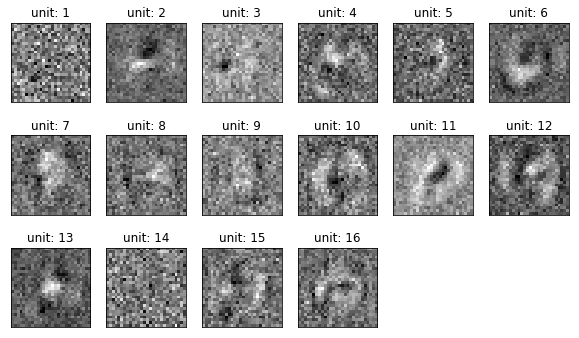

In [128]:
# Plot the weights
    ### Add your code here. ###
W1 = model.predictor.l1.W.data
W2 = model.predictor.l2.W.data
W3 = model.predictor.l3.W.data

print(W1.shape)

plt.figure(figsize = ([10,10]))

for i in range(0, W1.shape[0]):
    plt.subplot(5,6,i+1)
    fig = plt.imshow(W1[i, :].reshape((28,28)).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("unit: " + str(i+1))
    #plt.show()


### Exercise 3: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on an image. We first choose an image: 

[]

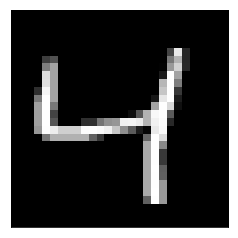

In [53]:
image = train[2][0].reshape((28, 28))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
ax.set_xticks([], []) ; ax.set_yticks([], [])

1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolved2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 3

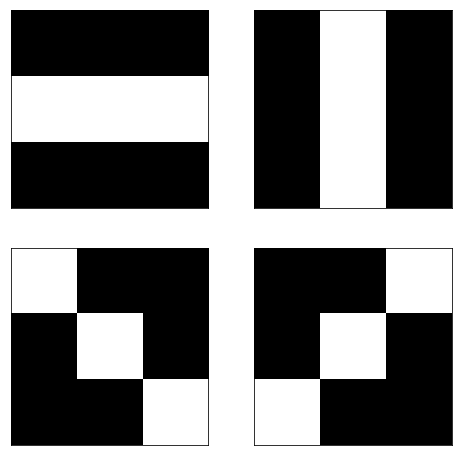

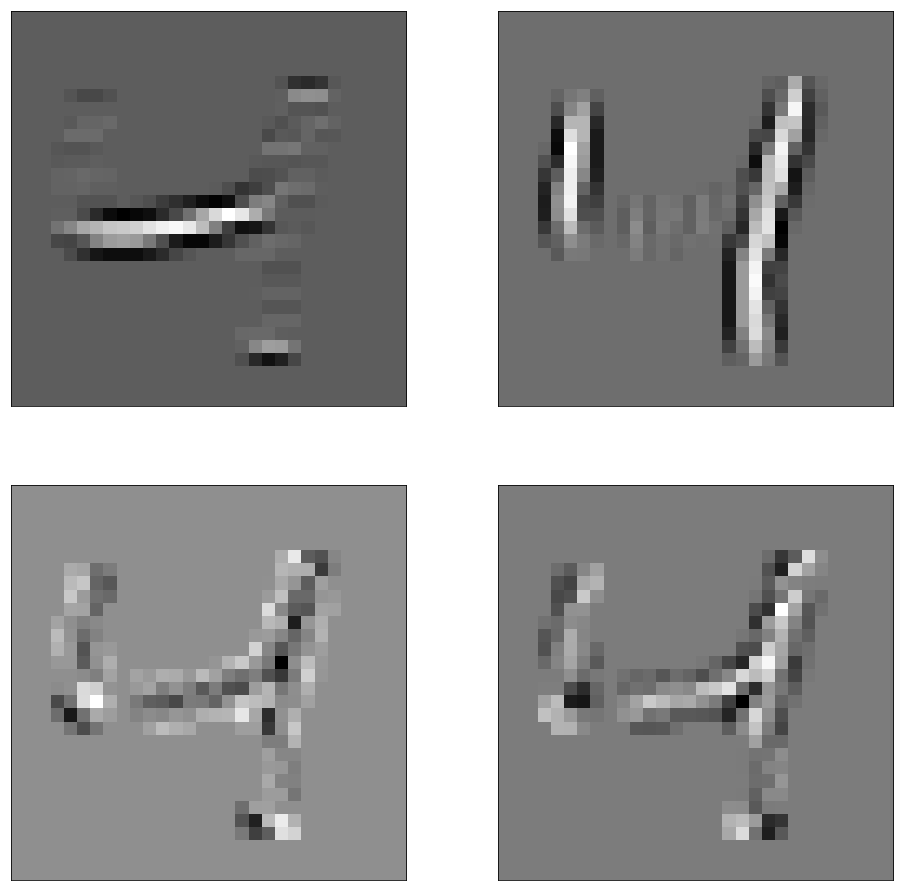

In [140]:
from scipy.signal import convolve2d
# 1. Create kernels
kernel_template = [ [-1.0, -1.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0, -1.0, -1.0] ]   # example: point detector
    ### Add your code here. ###

#Horizontal
kernel_template1 = [  [-1.0, -1.0, -1.0], 
                [ 2.0,  2.0,  2.0], 
                [-1.0, -1.0, -1.0] ]

#Vertical
kernel_template2 =[  [-1.0,  2.0, -1.0], 
                [-1.0,  2.0, -1.0], 
                [-1.0,  2.0, -1.0] ]

#Diagonal-down
kernel_template3 =[ [ 2.0, -1.0, -1.0], 
                [-1.0,  2.0, -1.0], 
                [-1.0, -1.0,  2.0] ]

#Diagonal-up
kernel_template4 =[ [-1.0, -1.0,  2.0], 
                [-1.0,  2.0, -1.0], 
                [ 2.0, -1.0, -1.0] ] 
# 2. Plot kernels
    ### Add your code here. ###
_, ax = plt.subplots(2,2, figsize = (8,8))
ax = ax.flatten()
for i in range(0, len(ax)):
    ax[i].set_xticks([],[]) 
    ax[i].set_yticks([],[])
ax[0].imshow(kernel_template1, cmap = "gray", interpolation = "nearest")
ax[1].imshow(kernel_template2, cmap = "gray", interpolation = "nearest")
ax[2].imshow(kernel_template3, cmap = "gray", interpolation = "nearest")
ax[3].imshow(kernel_template4, cmap = "gray", interpolation = "nearest")

# 3. Convolve the image with the kernels
    ### Add your code here. ###
img1 = convolve2d(kernel_template1, image)
img2 = convolve2d(kernel_template2, image)
img3 = convolve2d(kernel_template3, image)
img4 = convolve2d(kernel_template4, image)
# 4. Plot the activity maps
    ### Add your code here. ###

fig, ax = plt.subplots(2,2, figsize = (16,16))
ax = ax.flatten()
for i in range(0, len(ax)):
    ax[i].set_xticks([],[]) 
    ax[i].set_yticks([],[])
ax[0].imshow(img1, cmap="gray")
ax[1].imshow(img2, cmap="gray")
ax[2].imshow(img3, cmap="gray")
ax[3].imshow(img4, cmap="gray")


### Exercise 4 (3 points)

We want to train a convolutional neural network (CNN) next. Check [this project](https://github.com/vdumoulin/conv_arithmetic) to get intuition for the operations in convolutional neural network layers. 


1. Create `class CNN(Chain)` that should contain the new model. It will be similar to the `MLP` class, so you can start by copying the code of the MLP model class. 
1. The network should have one [2D-convolutional layer](https://docs.chainer.org/en/stable/reference/links.html). The first layer `conv1` should have 4x4 kernels, a stride of 1 and 10 output channels. As in the MLP, a second `Linear` layer should connect with the output units. 
1. Use ReLU activation functions on the convolutional layer activation.
1. Add 2D max-pooling with a `(2,2)` pooling window after the convolutional layer. 
1. Copy the rest of the training code underneath and adapt it so that it uses your `CNN` model. Change the plot file name to `cnn_plot.png`. Run the model for 30 full iterations through the training set and embed `cnn_plot.png` as before. The output directory should be `cnn_output_folder` now. **Please additionally attach `cnn_plot.png` to your submission.**

This will take a while to run. You can test the code by reducing the number of output channels of `conv1` first.  Usually you would train ConvNets on GPUs, which implement many of the linear algebra operations that are used here much more efficiently. 

In [129]:
# Load the MNIST data set in shape 1x28x28-length (the 2D shape is necessary for the convolutional layer): 
train, test = datasets.get_mnist(ndim=3)
print("Shape of a single example:", train[0][0].shape)

Shape of a single example: (1, 28, 28)


### Solution 4

In [132]:
# Your CNN, including output
    ### Add your code here. ###
train_iter = iterators.SerialIterator(train, batch_size = 100, shuffle = True)
test_iter = iterators.SerialIterator(test, batch_size = 100, repeat = False, shuffle = False)

class CNN(Chain):
    def __init__(self, n_units, n_out):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1_l2 = L.Convolution2D(None, out_channels = 10, ksize = (4,4), stride = 1)
            self.l3 = L.Linear(None, n_out)
        
    def __call__(self, x):
        h1 = F.relu(self.conv1_l2(x))
        h2 = F.max_pooling_2d(h1, ksize = (2,2))
        y = self.l3(h2)
        return y
    
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({"loss: ": loss, "accuracy: " : accuracy}, self)
        return loss
    
model = L.Classifier(CNN(16,10))
optimizer = optimizers.SGD()#lr = 0.001)
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (30, 'epoch'), out='cnn_output_folder')

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"]))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(["main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"], file_name = "cnn_plot.png"))
trainer.run()


epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
     total [..................................................]  0.56%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 30 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  1.11%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 30 epochs
    19.774 iters/sec. Estimated time to finish: 0:15:00.187449.
     total [..................................................]  1.67%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 30 epochs
    20.127 iters/sec. Estimated time to finish: 0:14:39.407581.
     total [#.................................................]  2.22%
this epoch [#################################.................] 66.67%
       400 iter, 0 epoch / 30 epochs
    20.173 it

     total [#########.........................................] 18.33%
this epoch [#########################.........................] 50.00%
      3300 iter, 5 epoch / 30 epochs
     18.07 iters/sec. Estimated time to finish: 0:13:33.488604.
     total [#########.........................................] 18.89%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 30 epochs
    18.128 iters/sec. Estimated time to finish: 0:13:25.381160.
     total [#########.........................................] 19.44%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 30 epochs
    18.174 iters/sec. Estimated time to finish: 0:13:17.829606.
6           0.93175        0.9371                    0.241832    0.223546              
     total [##########........................................] 20.00%
this epoch [..................................................]  0.00%
      3600 iter, 6 epoch / 30 epochs
    

     total [##################................................] 36.11%
this epoch [#########################################.........] 83.33%
      6500 iter, 10 epoch / 30 epochs
    18.133 iters/sec. Estimated time to finish: 0:10:34.191839.
11          0.951283       0.9539                    0.175879    0.163095              
     total [##################................................] 36.67%
this epoch [..................................................]  0.00%
      6600 iter, 11 epoch / 30 epochs
    18.005 iters/sec. Estimated time to finish: 0:10:33.148532.
     total [##################................................] 37.22%
this epoch [########..........................................] 16.67%
      6700 iter, 11 epoch / 30 epochs
    18.029 iters/sec. Estimated time to finish: 0:10:26.751672.
     total [##################................................] 37.78%
this epoch [################..................................] 33.33%
      6800 iter, 11 epoch / 30 epochs


     total [##########################........................] 53.89%
this epoch [########..........................................] 16.67%
      9700 iter, 16 epoch / 30 epochs
    17.955 iters/sec. Estimated time to finish: 0:07:42.267805.
     total [###########################.......................] 54.44%
this epoch [################..................................] 33.33%
      9800 iter, 16 epoch / 30 epochs
    17.967 iters/sec. Estimated time to finish: 0:07:36.393200.
     total [###########################.......................] 55.00%
this epoch [#########################.........................] 50.00%
      9900 iter, 16 epoch / 30 epochs
    17.963 iters/sec. Estimated time to finish: 0:07:30.933281.
     total [###########################.......................] 55.56%
this epoch [#################################.................] 66.67%
     10000 iter, 16 epoch / 30 epochs
    17.965 iters/sec. Estimated time to finish: 0:07:25.303534.
     total [############

     total [###################################...............] 71.67%
this epoch [#########################.........................] 50.00%
     12900 iter, 21 epoch / 30 epochs
    17.812 iters/sec. Estimated time to finish: 0:04:46.318123.
     total [####################################..............] 72.22%
this epoch [#################################.................] 66.67%
     13000 iter, 21 epoch / 30 epochs
    17.907 iters/sec. Estimated time to finish: 0:04:39.223861.
     total [####################################..............] 72.78%
this epoch [#########################################.........] 83.33%
     13100 iter, 21 epoch / 30 epochs
    17.909 iters/sec. Estimated time to finish: 0:04:33.606693.
22          0.971517       0.9708                    0.104863    0.0994029             
     total [####################################..............] 73.33%
this epoch [..................................................]  0.00%
     13200 iter, 22 epoch / 30 epochs


     total [############################################......] 89.44%
this epoch [#########################################.........] 83.33%
     16100 iter, 26 epoch / 30 epochs
    17.434 iters/sec. Estimated time to finish: 0:01:48.985403.
27          0.9757         0.9739                    0.0905765   0.0861772             
     total [#############################################.....] 90.00%
this epoch [..................................................]  0.00%
     16200 iter, 27 epoch / 30 epochs
    17.331 iters/sec. Estimated time to finish: 0:01:43.861531.
     total [#############################################.....] 90.56%
this epoch [########..........................................] 16.67%
     16300 iter, 27 epoch / 30 epochs
    17.321 iters/sec. Estimated time to finish: 0:01:38.148205.
     total [#############################################.....] 91.11%
this epoch [################..................................] 33.33%
     16400 iter, 27 epoch / 30 epochs


Embed `cnn_plot.png`: 

<img src = "cnn_output_folder/cnn_plot.png">

### Exercise 5 (0.5 points)
The input layer weights that the ConvNet has learned can be found in `model.predictor.conv1.W.data`. Plot them below (as we did in the MLP and autoencoder exercises).

### Solution 5

(10, 1, 4, 4)


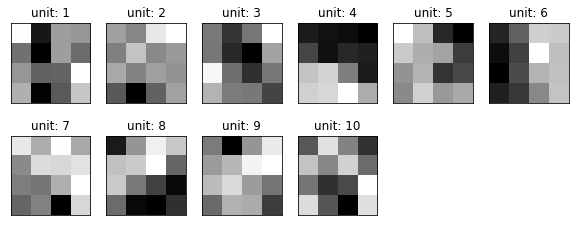

In [138]:
# Plot the weights
    ### Add your code here. ###
W1 = model.predictor.conv1_l2.W.data

print(W1.shape)

plt.figure(figsize = ([10,10]))

for i in range(0, W1.shape[0]):
    plt.subplot(5,6,i+1)
    fig = plt.imshow(W1[i, :].reshape((4,4)).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("unit: " + str(i+1))
    #plt.show()


### Exercise 6 (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 

1. The main difference of the models is the type of the first layer. What leads to the success of the first layer of the better-performing model? 

1. Explain ways in which the convolution operation and the resulting feature maps are biologically plausible (1 way) and biologically implausible (1 way). 

### Solution 6
1. Write your answer here.

Speed is the first big difference between the MLP and CNN models. The MLP model completed the classification in 108.985 seconds while the CNN did it in 1016.034 seconds. 

However, when comparing the accuracy we see that the longer wait times for the CNN are worth it. The CNN model finished with a main/accuracy of 97.72% and a validation/main/accuracy of 97.66%. Meanwhile, the MLP ended with a main/accuracy of 89.785% and a validation/main/accuracy of 90.049%. 

From this we can see that we have an 8.45% increase in the validation/main/accuracy from the CNN compared to the MLP.
2. Write your answer here.

Convolution performs better for a couple of reasons. Firstly, it reduces the number of free parameters by sharing weights. Secondly, and especially for our task, convolution allows for feature detection regardless of their position in the visual field.
Furthermore, pooling, allows for a stronger tolerance to small displacements in the input. 

3. Write your answer here.

Convolution operations are biologically plausible in the way that their operation has a distinct similarity to the way biological neurons work, that is, in a hierarchical feed-forward method. 



You can play around further with your code for this assignment by replacing the MNIST dataset with a more interesting / difficult to solve data set. For instance, you could use: 

`chainer.datasets.get_cifar10()`  ([CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) - photos of 10 natural object classes)

and 

`chainer.datasets.get_svhn()`  ([SVHN](http://ufldl.stanford.edu/housenumbers/) - house numbers from Google StreetView)